In [15]:
# 1. Imports and Setup
import os
from io import BytesIO
from PIL import Image
import yaml
from urllib.parse import quote


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import rasterio

import openai
from huggingface_hub import HfApi

%load_ext autoreload
%autoreload 2

import src.satellite as satellite
# using satellite.fetch_esri_from_coords and satellite.get_coords_from_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# get key and define global variables

PATH_TO_SECRETS = ".secrets.yml"
with open(PATH_TO_SECRETS, "r") as file:
    secrets = yaml.safe_load(file)

OPENAI_KEY = secrets["openai_key"]
HUGGINGFACE_KEY = secrets["huggingface_key"]

PATH_TO_METADATA = "data/metadata/cms_brazil_lidar_tile_metadata.csv"
PATH_TO_DATA = "data/processed/dtm"

HUGGINGFACE_REPO = "levjam/openai_to_z_upload"
FILENAME = "RIB_A01_2014_laz_2_fnands.tif"

INDEX = 0

In [29]:
# 2. Hillshade function
def hillshade(array, azimuth=315, angle_altitude=45):
    """
    Return a hillshade (shaded relief) of a DEM array.
    """
    ls = LightSource(azdeg=azimuth, altdeg=angle_altitude)
    return ls.hillshade(array, vert_exag=1, dx=1, dy=1)

# 3. DTM and Hillshade Plotting
def plot_dtm_and_hillshade(dem, hs, vmin, vmax, title):
    """
    Display DTM and hillshade images side by side.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(dem, cmap='terrain', vmin=vmin, vmax=vmax)
    plt.title(f"DTM: {title}")
    plt.colorbar(fraction=0.04, pad=0.02, label='Elevation (m)')
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.imshow(hs, cmap='gray')
    plt.title(f"Hillshade: {title}")
    plt.axis('off')
    plt.show()

def process_dtm_tile_array(dtm_path):
    """
    Process a DTM file: clean, auto-clip, compute hillshade, display.
    Returns (dem, hs).
    """
    title = os.path.basename(dtm_path)
    with rasterio.open(dtm_path) as src:
        dem = src.read(1)
        nodata = src.nodata
        # Mask nodata, extreme DEM outliers, replace with nan:
        dem = np.where((dem == nodata) | (dem < -100) | (dem > 9999), np.nan, dem)
        # Dynamic range for color (remove outliers)
        vmin = np.nanpercentile(dem, 1)
        vmax = np.nanpercentile(dem, 99)
        # Fill NaNs for hillshading (otherwise hillshade shows white gaps)
        dem_filled = np.nan_to_num(dem, nan=np.nanmean(dem))
        hs = hillshade(dem_filled, azimuth=315, angle_altitude=45)
        plot_dtm_and_hillshade(dem, hs, vmin, vmax, title)
    return dem, hs

In [30]:
def array_to_pil(arr, cmap='terrain', vmin=None, vmax=None):
    """Render a numpy array as a PIL image with colormap."""
    plt.ioff()
    fig, ax = plt.subplots(figsize=(6,6), dpi=100)
    ax.axis('off')
    im = ax.imshow(arr, cmap=cmap, vmin=vmin, vmax=vmax)
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf)

def get_image_bytes(arr, cmap='terrain', vmin=None, vmax=None):
    pil_img = array_to_pil(arr, cmap, vmin, vmax)
    buf = BytesIO()
    pil_img.save(buf, format='PNG')
    buf.seek(0)
    return buf

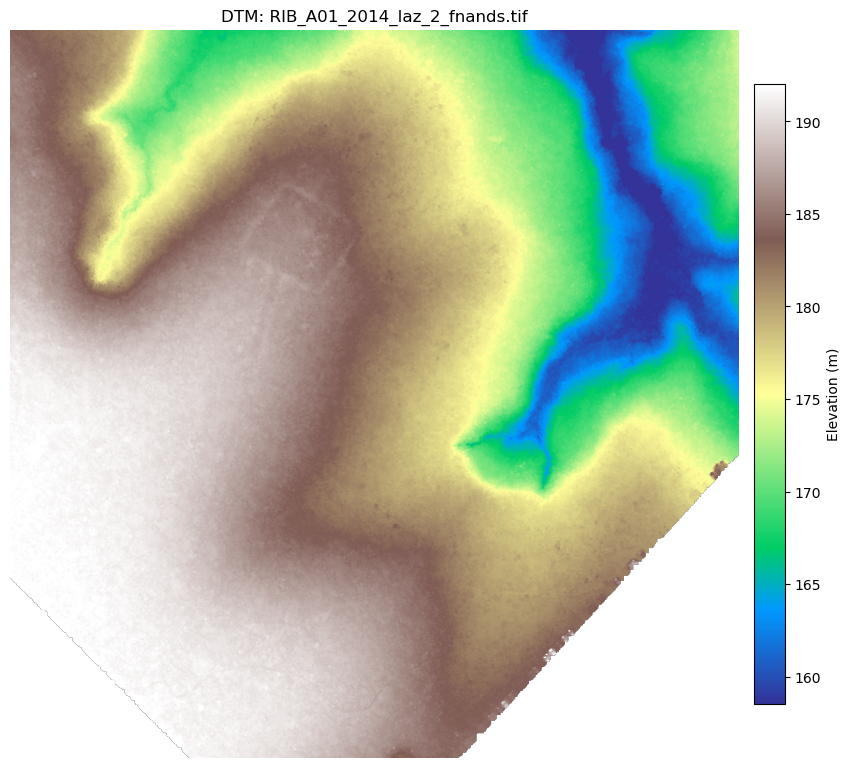

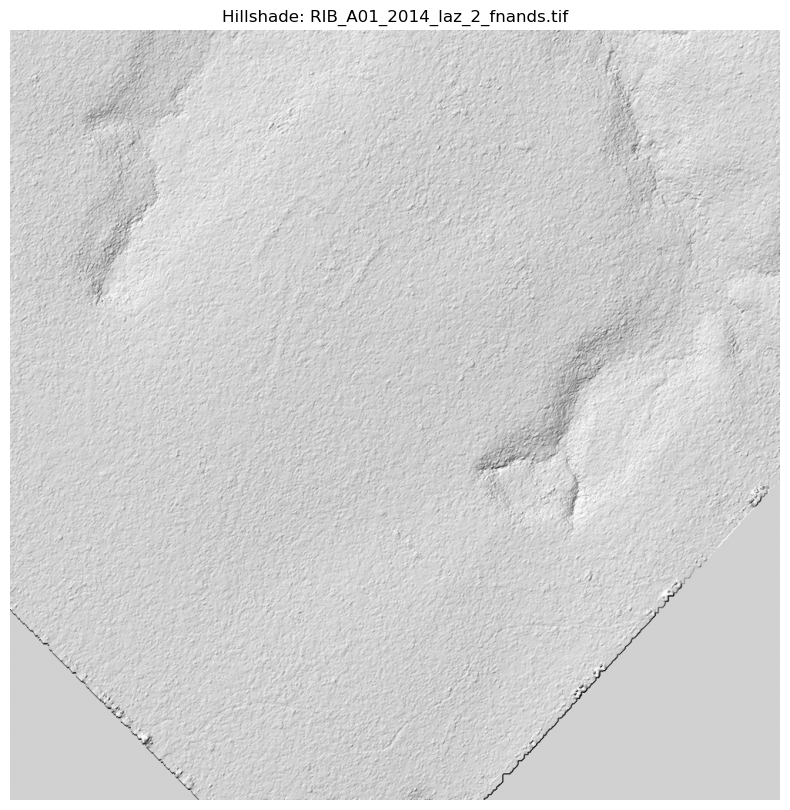

In [33]:
# 2. List DTM files
dtm_files = [f for f in os.listdir(PATH_TO_DATA) if f.lower().endswith('.tif')]
# print(dtm_files[:5])

# 3. Load the metadata CSV
meta = pd.read_csv(PATH_TO_METADATA)
# print(meta.head())

# example_file = sorted([f for f in os.listdir(PATH_TO_DATA) if f.lower().endswith('.tif')])[INDEX]
# filename = meta.iloc[INDEX]["filename"]
filename = FILENAME

dtm_path = os.path.join(PATH_TO_DATA, FILENAME)

dem, hs = process_dtm_tile_array(dtm_path)


In [34]:
dtm_png_buf = get_image_bytes(dem, cmap='terrain', vmin=np.nanpercentile(dem,1), vmax=np.nanpercentile(dem,99))
hs_png_buf  = get_image_bytes(hs,  cmap='gray')

In [35]:
# Upload images as before
dtm_filename = f"dtm_{filename}.png"
hs_filename  = f"hs_{filename}.png"

hf_api = HfApi()

dtm_url = hf_api.upload_file(
    path_or_fileobj=dtm_png_buf,
    path_in_repo=f"dtm_{filename}.png",
    repo_id=HUGGINGFACE_REPO,
    repo_type="dataset",
    token=HUGGINGFACE_KEY
)
hs_url = hf_api.upload_file(
    path_or_fileobj=hs_png_buf,
    path_in_repo=f"hs_{filename}.png",
    repo_id=HUGGINGFACE_REPO,
    repo_type="dataset",
    token=HUGGINGFACE_KEY
)
# --- Construct resolved URLs ---
# Repo info
user, repo = HUGGINGFACE_REPO.split('/')
dtm_resolved_url = f"https://huggingface.co/datasets/{user}/{repo}/resolve/main/{quote(dtm_filename)}"
hs_resolved_url  = f"https://huggingface.co/datasets/{user}/{repo}/resolve/main/{quote(hs_filename)}"

print("DTM PAGE URL:", dtm_url)
print("DTM RESOLVE URL:", dtm_resolved_url)
print("HS  PAGE URL:", hs_url)
print("HS  RESOLVE URL:", hs_resolved_url)

DTM PAGE URL: https://huggingface.co/datasets/levjam/openai_to_z_upload/blob/main/dtm_RIB_A01_2014_laz_2_fnands.tif.png
DTM RESOLVE URL: https://huggingface.co/datasets/levjam/openai_to_z_upload/resolve/main/dtm_RIB_A01_2014_laz_2_fnands.tif.png
HS  PAGE URL: https://huggingface.co/datasets/levjam/openai_to_z_upload/blob/main/hs_RIB_A01_2014_laz_2_fnands.tif.png
HS  RESOLVE URL: https://huggingface.co/datasets/levjam/openai_to_z_upload/resolve/main/hs_RIB_A01_2014_laz_2_fnands.tif.png


In [36]:
# user = "levjam"
# repo = "openai_to_z_upload"
# filename = "hs_ANA_A01_2017_laz_0.laz.png"
# direct_url = f"https://huggingface.co/datasets/{user}/{repo}/resolve/main/{filename}"
# print(direct_url)

In [37]:
# The URLs returned from Hugging Face
# dtm_url and hs_url from your previous upload code
prompt_text = (
    "You are an expert in archaeological remote sensing. "
    "The first image is a digital terrain model (DTM); the second is its hillshade rendering. "
    "Please identify and describe any patterns, shapes, or anomalies that could indicate archaeological features, and mention their approximate location in the tile."
)

response = openai.chat.completions.create(
    model="gpt-4o",  # "gpt-4o" also works if you have access
    messages=[
        {"role": "system", "content": "You are a world-class expert in analyzing geospatial data and identifying archaeological remains from DTMs and hillshade images."},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt_text},
                {"type": "image_url", "image_url": {"url": dtm_resolved_url}},
                {"type": "image_url", "image_url": {"url": hs_resolved_url}}
            ]
        },
    ],
    max_tokens=800
)

print(response.choices[0].message.content)

In the provided DTM and hillshade images, a square or rectangular shape is visible near the center left. This geometric feature is likely indicative of a man-made structure or enclosure, possibly suggesting archaeological remains such as a building foundation or ancient fortification. Its defined linear boundaries and regular shape distinguish it from the natural terrain.

Other features might be visible, but this specific shape stands out due to its geometry and orientation, which differ from the surrounding natural landscape. Further ground investigation would be needed to confirm its archaeological significance.
